# LANL dataset stats

This notebook explores the data from the LANL database

In this notebook, we explore:
- Basic dataset stats


### Prepare the dataset

Run the preparation for the dataset with the `prepare_data` and `setup` methods.

In [2]:
from datasets.LANL_local import LANLL
from ordered_set import OrderedSet

dataset = LANLL("/data/datasets", lanl_URL="https://csr.lanl.gov/data-fence/1751407561/mt99_A6PRlVu9-k6lZ0IQ-DbX5E=/cyber1/")

dataset.prepare_data()
dataset.setup(stage="fit")

In [10]:
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

def LANL_to_df(dataset, from_ts, to_ts):
    columns = [
        'time',
        'source user@domain',
        'destination user@domain',
        'source computer',
        'destination computer',
        'authentication type',
        'logon type',
        'authentication orientation',
        'success/failure'
    ]

    df = pd.DataFrame([])
    for part in tqdm(pd.read_csv(
            dataset.auth_file["file"], 
            sep=',', 
            compression='gzip',
            chunksize=100000, 
            iterator=True, 
            names=columns, 
            header=None),
            desc = "Generating dataframe"):
        df = pd.concat([df, part])
        
        if part["time"].min() > to_ts:
            break

    return df

def count_updates(ordered_set: OrderedSet, update):
    set_size = len(ordered_set)
    ordered_set.update(update)
    new_size = len(ordered_set)
    return new_size - set_size

def process_batch(batch, keyword_map, hostmap, usermap, added_items_per_bin, stage):
    # Go trough every bin
    for bin in batch:
        # Update keyword map
        for col in keyword_map.keys():
            diff = count_updates(keyword_map[col], bin[col].dropna().unique())
            added_items_per_bin[col].append(diff)
        
        diff1 = count_updates(hostmap, bin["source computer"].dropna().unique())
        diff2 = count_updates(hostmap, bin["destination computer"].dropna().unique())
        added_items_per_bin["hosts"].append(diff1 + diff2)

        diff1 = count_updates(usermap, bin["source user@domain"].dropna().unique())
        diff2 = count_updates(usermap, bin["destination user@domain"].dropna().unique())
        added_items_per_bin["services"].append(diff1 + diff2)

        added_items_per_bin["stage"].append(stage)


def show_plot_no_stage(df: pd.DataFrame, cols = ["hosts"]):
    clear_output(wait=True)
    df.index = df.index/dataset.batch_size
    ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")
    plt.title("LANL Unique values")
    plt.grid(True)
    plt.show()

def show_plot_with_stage(df: pd.DataFrame, cols = ["hosts"]):
    # Sort by stage
    df.index.name = "index"
    df = df.sort_values(["stage", "index"])
    df = df.reset_index(drop=True)

    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    # Plot the data
    df.index = df.index/dataset.batch_size
    ax = df[cols].cumsum().plot(xlabel="batch", ylabel="Unique count")

    # Get unique stages and their x ranges
    for stage, group in df.groupby("stage"):
        x_start = group.index.min()
        x_end = group.index.max()

        stage_label = "Training"
        color = (0,1,0)
        if stage == 1:
            stage_label = "Validation"
            color = (1,1,0)
        if stage == 2:
            stage_label = "Testing"
            color = (1,0,0)

        plt.axvspan(x_start, x_end, alpha=0.2, label=stage_label, color=color)

    plt.title("LANL Unique values by Stage")
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_maps():
    # Get dataset columns
    columns = list(next(iter(dataset.generate_bins())).columns)

    # Generate keymaps
    exclude_columns = [
        "time",
        "source computer",
        "destination computer",
        "source user@domain",
        "destination user@domain"
    ]
    keyword_map = {col: OrderedSet([]) for col in columns if col not in exclude_columns}
    hostmap = OrderedSet([])
    usermap = OrderedSet([])

    # Keep track of the added values per column
    added_items_per_bin = {col: [] for col in columns if col not in exclude_columns}
    added_items_per_bin["hosts"] = []
    added_items_per_bin["services"] = []
    added_items_per_bin["stage"] = []

    return keyword_map, hostmap, usermap, added_items_per_bin

### Graph unique (unseen) values
This shows per time bin how many new/unseen values have been observed for every time bin.
- x axis -> each time bin
- y axis -> percentage of unique values

In [44]:
import pandas as pd
from tqdm import tqdm

def LANL_unique(dataset):
    keyword_map, hostmap, usermap, added_items_per_bin = generate_maps()

    for batch, stage in tqdm(dataset.generate_batches(),
                                         "Extracting data from batches", total=175):
        process_batch(batch, keyword_map, hostmap, usermap, added_items_per_bin, stage)
    
    df = pd.DataFrame(added_items_per_bin)
    df.to_parquet("LANL_keywordmap_percent.parquet")

LANL_unique(dataset)

Extracting data from batches:  99%|█████████▉| 173/175 [44:52<00:31, 15.56s/it]


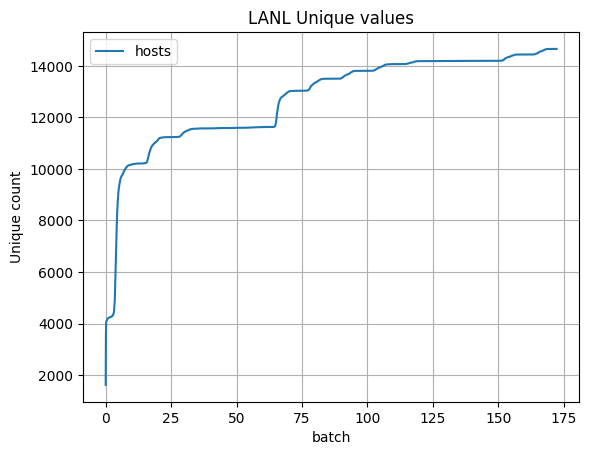

In [45]:
df = pd.read_parquet("LANL_keywordmap_percent.parquet")
show_plot_no_stage(df)

<Figure size 1000x500 with 0 Axes>

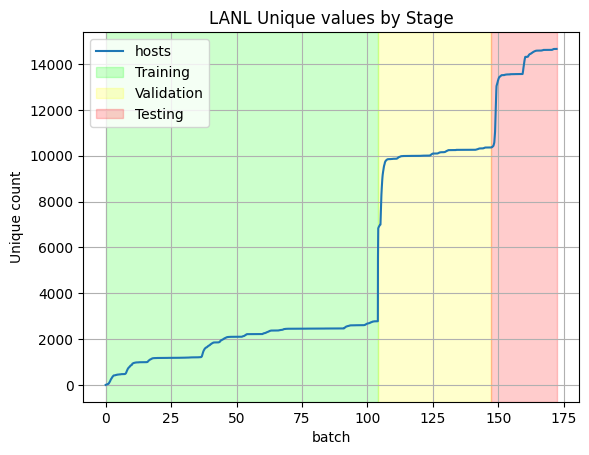

In [46]:
show_plot_with_stage(df)

In [11]:
df = LANL_to_df(dataset, 0, 1209600)

Generating dataframe: 900it [57:50,  3.86s/it]


KeyboardInterrupt: 

In [1]:
import pandas as pd

columns = [
    'time'
]

df = pd.read_parquet("/data/Try1/LANL.parpquet", columns=columns)

malicious = "/data/datasets/LANL/redteam.txt.gz"
redteam_header = [
    "time",
    "user@domain",
    "source computer",
    "destination computer"
]
mal = pd.read_csv(
            malicious, 
            sep=',', 
            compression='gzip',
            names=redteam_header, 
            header=None)

In [4]:
mal = mal[mal["time"] <= 1209600]